<a href="https://colab.research.google.com/github/jasonnho/flygaruda-sentiment-analysis/blob/main/notebook/flygaruda_bow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('flygaruda_reviews_clean_label.csv')

In [ ]:
TEXT_COL = "text_clean"
df[[TEXT_COL, "score", "sentiment"]].head()

,text_clean,score,sentiment
0,ajar kau kritik enak sorry sayang no pakai,4,positive
1,maskapai maling tipu customer informasi info e...,1,negative
2,platinum turun bijak tahan kayak pakai poin an...,2,negative
3,delay jam terbang sore hai hotel transportasi ...,1,negative
4,checkin boarding tiket cuman,4,positive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4610 entries, 0 to 4609
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   content                      4610 non-null   object 
 1   content_stemmed_no_common_2  4610 non-null   object 
 2   content_regex                4610 non-null   object 
 3   content_regex_norm           4610 non-null   object 
 4   text_clean                   4610 non-null   object 
 5   _tokens                      4610 non-null   object 
 6   tokens_clean                 4610 non-null   object 
 7   score                        4610 non-null   int64  
 8   sentiment                    4610 non-null   object 
 9   reviewCreatedVersion         3154 non-null   object 
 10  major_version                3154 non-null   float64
 11  at                           4610 non-null   object 
 12  thumbsUpCount                4610 non-null   int64  
dtypes: float64(1), int

In [ ]:
# Inisialisasi CountVectorizer dan transform teks -> BoW matrix

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    analyzer="word",
    ngram_range=(1, 1),     # unigram
    min_df=1,               # kata harus muncul minimal di 1 dokumen
    max_df=1.0,             # jangan buang kata umum dulu; kita eksplor dulu
    lowercase=False,        # text_clean sudah lowercase
    token_pattern=r"(?u)\b\w+\b"  # token kata umum
)

# Fit & transform
X = vectorizer.fit_transform(df[TEXT_COL])

# Info dasar
n_docs, n_feats = X.shape
feat_names = vectorizer.get_feature_names_out()

print(f"Shape BoW: {X.shape}  (dokumen x fitur)")
print(f"Jumlah fitur (vocab): {n_feats}")
print("Contoh 20 fitur pertama:", feat_names[:20])

density = X.nnz / (n_docs * n_feats)
print(f"Density matrix: {density:.6f}")

BOW_MATRIX = X
FEATURE_NAMES = feat_names


Shape BoW: (4610, 1336)  (dokumen x fitur)
Jumlah fitur (vocab): 1336
Contoh 20 fitur pertama: ['a' 'abal' 'ac' 'acces' 'account' 'activity' 'adik' 'admin' 'aduh'
 'again' 'agen' 'agustus' 'ah' 'air' 'airasia' 'airline' 'airlines'
 'airplane' 'airport' 'aja']
Density matrix: 0.002853


Top 20 kata paling sering (BoW):


,word,count
99,bagus,382
428,good,353
494,indonesia,321
116,bantu,319
791,mudah,295
767,miles,279
102,baik,261
679,login,236
717,mantap,228
1273,update,215


<Figure size 800x500 with 0 Axes>

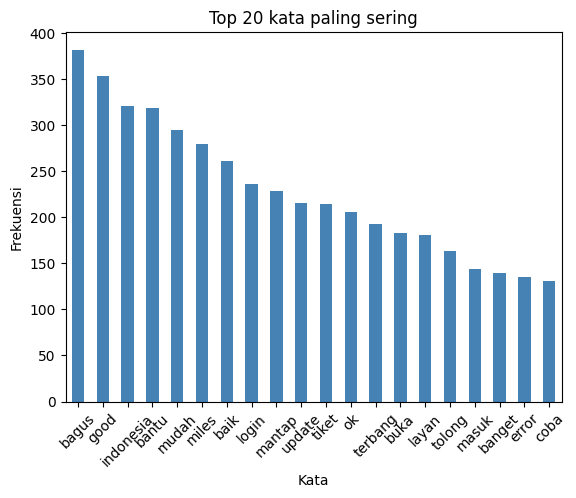

In [ ]:
# Hitung total frekuensi kata di seluruh dokumen
word_counts = np.asarray(BOW_MATRIX.sum(axis=0)).ravel()

# Buat DataFrame
bow_freq = pd.DataFrame({
    "word": FEATURE_NAMES,
    "count": word_counts
}).sort_values(by="count", ascending=False)

# Top 20 kata
print("Top 20 kata paling sering (BoW):")
display(bow_freq.head(20))

# Distribusi frekuensi kata (opsional plot)
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
bow_freq.head(20).plot(kind="bar", x="word", y="count", legend=False, color="steelblue")
plt.title("Top 20 kata paling sering")
plt.ylabel("Frekuensi")
plt.xlabel("Kata")
plt.xticks(rotation=45)
plt.show()

Jumlah dokumen per label:
sentiment
positive    2964
negative    1252
neutral      394
Name: count, dtype: int64

Top kata POSITIVE:


,word,pos
428,good,342
99,bagus,288
116,bantu,272
791,mudah,257
717,mantap,222
494,indonesia,206
848,ok,186
650,layan,145
1207,tiket,114
1178,terbang,114



Top kata NEGATIVE:


,word,neg
767,miles,170
679,login,162
102,baik,153
193,buka,144
1273,update,141
1222,tolong,103
893,password,102
1142,susah,100
729,masuk,100
346,error,95



Top kata NEUTRAL:


,word,neu
679,login,43
767,miles,41
102,baik,38
1273,update,36
1222,tolong,33
494,indonesia,30
245,coba,29
99,bagus,28
101,bahasa,26
1178,terbang,25


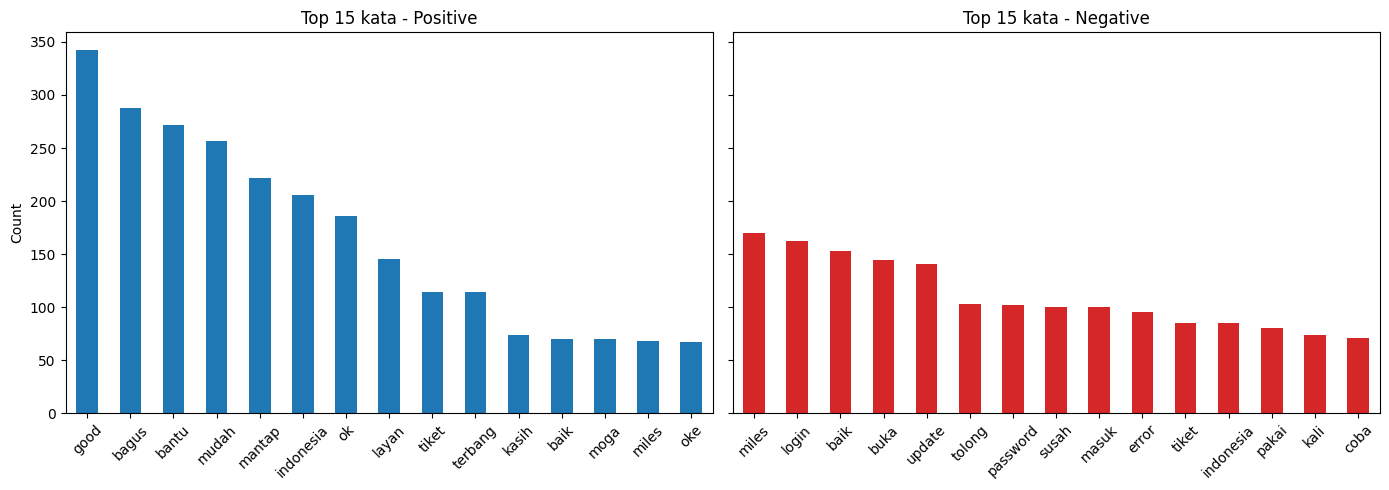

In [ ]:
assert "sentiment" in df.columns, "Kolom 'sentiment' tidak ada di df."

# mask per label
mask_pos = (df["sentiment"] == "positive").values
mask_neg = (df["sentiment"] == "negative").values
mask_neu = (df["sentiment"] == "neutral").values


print("Jumlah dokumen per label:")
print(df["sentiment"].value_counts())

# hitung total frekuensi kata per label (sum baris BoW)
counts_pos = np.asarray(BOW_MATRIX[mask_pos].sum(axis=0)).ravel()
counts_neg = np.asarray(BOW_MATRIX[mask_neg].sum(axis=0)).ravel()
counts_neu = np.asarray(BOW_MATRIX[mask_neu].sum(axis=0)).ravel()

# susun ke DataFrame komparatif
bow_comp = pd.DataFrame({
    "word": FEATURE_NAMES,
    "pos": counts_pos,
    "neg": counts_neg,
    "neu": counts_neu
})
bow_comp["total"] = bow_comp[["pos","neg","neu"]].sum(axis=1)

# Top kata per label (berdasarkan count absolut)
topN = 20

print("\nTop kata POSITIVE:")
display(bow_comp.sort_values("pos", ascending=False).head(topN)[["word","pos"]])

print("\nTop kata NEGATIVE:")
display(bow_comp.sort_values("neg", ascending=False).head(topN)[["word","neg"]])

print("\nTop kata NEUTRAL:")
display(bow_comp.sort_values("neu", ascending=False).head(topN)[["word","neu"]])

# Visual kecil: 15 kata teratas di positive vs negative (barplot)
fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=True)

bow_comp.sort_values("pos", ascending=False).head(15).plot(
    x="word", y="pos", kind="bar", ax=axes[0], legend=False, title="Top 15 kata - Positive"
)
axes[0].set_xlabel(""); axes[0].set_ylabel("Count"); axes[0].tick_params(axis='x', rotation=45)

bow_comp.sort_values("neg", ascending=False).head(15).plot(
    x="word", y="neg", kind="bar", ax=axes[1], legend=False, title="Top 15 kata - Negative", color="tab:red"
)
axes[1].set_xlabel(""); axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
mask_pos = (df["sentiment"] == "positive").values
mask_neg = (df["sentiment"] == "negative").values
mask_neu = (df["sentiment"] == "neutral").values

# Hitung count per label dari BoW
counts_pos = np.asarray(BOW_MATRIX[mask_pos].sum(axis=0)).ravel()
counts_neg = np.asarray(BOW_MATRIX[mask_neg].sum(axis=0)).ravel()
counts_neu = np.asarray(BOW_MATRIX[mask_neu].sum(axis=0)).ravel()

# Total token (jumlah kemunculan kata) per label
N_pos = counts_pos.sum()
N_neg = counts_neg.sum()
N_neu = counts_neu.sum()

# Total korpus (gabungan semua label)
counts_all = counts_pos + counts_neg + counts_neu
N_all = counts_all.sum()
V = len(FEATURE_NAMES)

def log_odds_ratio(c_label, N_label, c_others, N_others, alpha=0.5):
    """
    Log-odds ratio dengan add-alpha smoothing (sederhana).
    Semakin besar -> semakin khas untuk 'label' dibanding 'others'.
    """
    # Prob kata pada label & others dengan smoothing add-alpha
    p_label  = (c_label  + alpha) / (N_label  + alpha * V)
    p_others = (c_others + alpha) / (N_others + alpha * V)

    # odds = p / (1 - p)
    odds_label  = p_label  / np.maximum(1 - p_label, 1e-12)
    odds_others = p_others / np.maximum(1 - p_others, 1e-12)

    # log-odds
    return np.log(np.maximum(odds_label, 1e-12)) - np.log(np.maximum(odds_others, 1e-12))

def top_salient_for_label(label_counts, label_total, name, topn=20, alpha=0.5):
    others_counts = counts_all - label_counts
    others_total  = N_all - label_total

    lor = log_odds_ratio(label_counts, label_total, others_counts, others_total, alpha=alpha)
    df_lor = pd.DataFrame({
        "word": FEATURE_NAMES,
        "log_odds": lor,
        "label_count": label_counts,
        "others_count": others_counts
    }).sort_values("log_odds", ascending=False)
    print(f"\nTop {topn} kata paling khas untuk label = {name}:")
    return df_lor.head(topn)

top_pos = top_salient_for_label(counts_pos, N_pos, "positive", topn=20, alpha=0.5)
display(top_pos)

top_neg = top_salient_for_label(counts_neg, N_neg, "negative", topn=20, alpha=0.5)
display(top_neg)

top_neu = top_salient_for_label(counts_neu, N_neu, "neutral", topn=20, alpha=0.5)
display(top_neu)


Top 20 kata paling khas untuk label = positive:


,word,log_odds,label_count,others_count
668,like,4.266189,25,0
150,best,4.068389,62,1
825,nice,4.018841,59,1
434,great,3.944449,18,0
717,mantap,3.890682,222,6
68,application,3.767162,15,0
428,good,3.765776,342,11
852,okey,3.377104,10,0
1234,traveling,3.377104,10,0
353,excellent,3.377104,10,0



Top 20 kata paling khas untuk label = negative:


,word,log_odds,label_count,others_count
899,payah,4.612148,45,0
537,jelek,4.417940,37,0
888,parah,3.396508,40,1
747,mending,3.393783,13,0
1029,sampah,3.316718,12,0
883,paksa,3.316718,12,0
436,gue,3.233232,11,0
1141,suruh,3.142156,10,0
144,berkali,3.142156,10,0
64,apl,3.041968,9,0



Top 20 kata paling khas untuk label = neutral:


,word,log_odds,label_count,others_count
168,bla,4.388199,6,0
815,neo,4.019761,4,0
998,request,3.768091,3,0
1321,xi,3.768091,3,0
332,egk,3.431262,2,0
671,lion,3.431262,2,0
680,loging,3.431262,2,0
215,cantum,3.431262,2,0
1045,sdh,3.431262,2,0
762,mgaruda,3.431262,2,0


In [ ]:
# Buat BoW dengan unigram + bigram (1,2)

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd

# Fit ulang CountVectorizer dengan ngram_range=(1,2)
vectorizer_bigram = CountVectorizer(
    analyzer="word",
    ngram_range=(1, 2),   # unigram + bigram
    min_df=2,             # hanya ambil ngram yg muncul >=2 dokumen biar nggak terlalu sparse
    lowercase=False,
    token_pattern=r"(?u)\b\w+\b"
)

X_bigram = vectorizer_bigram.fit_transform(df["text_clean"])
FEATURES_BIGRAM = vectorizer_bigram.get_feature_names_out()

print(f"Shape BoW bigram: {X_bigram.shape} (dokumen x fitur)")
print("Contoh 20 fitur:", FEATURES_BIGRAM[:20])

# Hitung frekuensi total tiap ngram
counts_bigram = np.asarray(X_bigram.sum(axis=0)).ravel()
bow_bigram_freq = pd.DataFrame({
    "ngram": FEATURES_BIGRAM,
    "count": counts_bigram
}).sort_values("count", ascending=False)

print("\nTop 20 ngram paling sering (unigram + bigram):")
display(bow_bigram_freq.head(20))


Shape BoW bigram: (4610, 2811) (dokumen x fitur)
Contoh 20 fitur: ['a' 'abal' 'ac' 'acces' 'account' 'activity' 'adik' 'admin'
 'admin tolong' 'aduh' 'again' 'agen' 'agustus' 'ah' 'air' 'air asia'
 'airasia' 'airline' 'airlines' 'airplane']

Top 20 ngram paling sering (unigram + bigram):


,ngram,count
135,bagus,382
852,good,353
977,indonesia,321
231,bantu,319
1686,mudah,295
1587,miles,279
176,baik,261
1393,login,236
1488,mantap,228
2663,update,215


In [ ]:
mask_pos = (df["sentiment"]=="positive").values
mask_neg = (df["sentiment"]=="negative").values

counts_pos_bg = np.asarray(X_bigram[mask_pos].sum(axis=0)).ravel()
counts_neg_bg = np.asarray(X_bigram[mask_neg].sum(axis=0)).ravel()

df_bigram_comp = pd.DataFrame({
    "ngram": FEATURES_BIGRAM,
    "pos": counts_pos_bg,
    "neg": counts_neg_bg
})
df_bigram_comp["total"] = df_bigram_comp["pos"] + df_bigram_comp["neg"]

print("Top 15 bigram di Positive:")
display(df_bigram_comp.sort_values("pos", ascending=False).head(15))

print("\nTop 15 bigram di Negative:")
display(df_bigram_comp.sort_values("neg", ascending=False).head(15))

Top 15 bigram di Positive:


,ngram,pos,neg,total
852,good,342,2,344
135,bagus,288,66,354
231,bantu,272,27,299
1686,mudah,257,24,281
1488,mantap,222,2,224
977,indonesia,206,85,291
1833,ok,186,9,195
1311,layan,145,32,177
2516,tiket,114,85,199
2453,terbang,114,54,168



Top 15 bigram di Negative:


,ngram,pos,neg,total
1587,miles,68,170,238
1393,login,31,162,193
176,baik,70,153,223
400,buka,19,144,163
2663,update,38,141,179
2560,tolong,27,103,130
1935,password,8,102,110
1520,masuk,29,100,129
2378,susah,10,100,110
712,error,20,95,115


In [ ]:
exclusive_pos = df_bigram_comp[(df_bigram_comp["pos"]>0) & (df_bigram_comp["neg"]==0)].sort_values("pos", ascending=False)
exclusive_neg = df_bigram_comp[(df_bigram_comp["neg"]>0) & (df_bigram_comp["pos"]==0)].sort_values("neg", ascending=False)

print("Bigram eksklusif Positive:")
display(exclusive_pos.head(10))

print("\nBigram eksklusif Negative:")
display(exclusive_neg.head(10))

Bigram eksklusif Positive:


,ngram,pos,neg,total
1784,nice,59,0,59
2498,the best,42,0,42
1361,like,25,0,25
1102,job,21,0,21
1486,mantab,21,0,21
1044,is the,19,0,19
860,good job,18,0,18
869,great,18,0,18
138,bagus bantu,18,0,18
2743,very good,18,0,18



Bigram eksklusif Negative:


,ngram,pos,neg,total
1971,payah,0,45,45
2111,putih,0,38,38
1095,jelek,0,37,37
1333,layar,0,33,33
572,cs,0,26,26
1335,layar putih,0,25,25
2188,rugi,0,20,20
2709,usaha,0,19,19
1806,not,0,15,15
1384,log in,0,15,15


In [ ]:
df_bow_table = pd.DataFrame(
    X[:100].toarray(),       # ambil 10 baris pertama & convert ke dense array
    columns=FEATURE_NAMES
)
df_bow_table.head()

,a,abal,ac,acces,account,activity,adik,admin,aduh,again,...,yah,yak,yasudahlah,yes,you,your,youtube,yth,z,zaman
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
